# Seminar 1: Introduction to PyTorch

## What is PyTorch?

PyTorch is an open-source machine learning framework used for:
- numerical computation with tensors
- building and training neural networks
- automatic differentiation (autograd)

It is widely used in research and production because it is:
- easy to use and Pythonic
- flexible (dynamic computation graphs)
- efficient on both CPUs and GPUs

For automatic differentiation PyTorch uses computational graph

---

## What is a Computation Graph?

A computation graph is a directed graph that represents:
- **nodes** → tensors (data)
- **edges** → operations applied to those tensors

PyTorch builds this graph **dynamically at runtime** as operations are executed.

Computation graphs allow PyTorch to:
- record every operation applied to tensors during the forward pass
- understand how each output is connected to its inputs
- automatically compute gradients using backpropagation

Because this graph is available, PyTorch can efficiently apply the chain rule
to propagate gradients backward through complex computations.

As a result, calling `.backward()` on a final tensor automatically computes
all required gradients without manually deriving them.


In [1]:
!pip install torchviz

In [2]:
def show_tensor_params(*tensors):
  for x in tensors:
    print('---')
    print(f"data - {x.data}")
    print(f"storage - {x.storage()}")
    print(f"grad_fn - {x.grad_fn}")
    print(f"req_grad - {x.requires_grad}")
    print(f"is_leaf - {x.is_leaf}")
    print(f"version - {x._version}")

In [3]:
import torch



In this example:
- `x` and `y` are input tensors (leaf nodes)
- operations like multiplication or additions create graph nodes
- `z` is the final output tensor

The visualized graph shows how data flows forward and how gradients will flow backward during training.

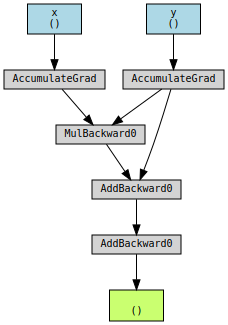

In [4]:
import torch
from torchviz import make_dot

# Create tensors
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# Simple operations
z = x * y + y + 2

# Visualize computation graph
dot = make_dot(z, params={"x": x, "y": y})
dot


In [5]:

z.backward()
x.grad

tensor(3.)

## Tensor in computation graph

In [6]:
x = torch.tensor(5.0)
show_tensor_params(x)

---
data - 5.0
storage -  5.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 1]
grad_fn - None
req_grad - False
is_leaf - True
version - 0


/tmp/ipykernel_36644/1850263541.py:5: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  print(f"storage - {x.storage()}")


- **data**
  - The actual numerical value(s) stored in the tensor
  - For a scalar tensor, this is a single number (e.g., `5.0`)
  - For higher-dimensional tensors, this is an array of values

- **storage**
  - The low-level memory buffer that holds the tensor’s data
  - Contains information about:
    - data type (`dtype`, e.g., `float32`)
    - device (`cpu` or `cuda`)
    - number of elements stored
  - Multiple tensors (such as views or slices) can share the same storage

- **grad_fn**
  - The function that created the tensor during an autograd-tracked operation
  - `None` means the tensor was created directly by the user
  - When present, it represents a node in the computation graph

- **requires_grad**
  - Indicates whether PyTorch should track operations on this tensor for gradient computation
  - If `False`, no gradients are computed
  - If `True`, gradients are computed during backpropagation

- **is_leaf**
  - Indicates whether the tensor is a leaf node in the computation graph
  - Leaf tensors are created directly by the user, not by operations
  - Only leaf tensors can have gradients stored in the `.grad` attribute

- **version**
  - Internal counter that tracks in-place modifications to the tensor
  - Incremented whenever the tensor is modified in-place (e.g., `+=`, `.add_()`)
  - Used by autograd to ensure correct gradient computation


In [7]:
x += 1

In [8]:
show_tensor_params(x)

---
data - 6.0
storage -  6.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 1]
grad_fn - None
req_grad - False
is_leaf - True
version - 1


### Backpropagation and Graph Deletion

In PyTorch, the computation graph is **freed after `.backward()` is called**.
This is done to save memory.

That means:
- After one backward pass, the graph no longer exists
- Calling `.backward()` again on the same graph will raise an error

---

### How to Keep the Graph and Use Multiple Backward Passes

To **prevent the graph from being deleted**, you must explicitly tell PyTorch to keep it.

You should keep the graph when:
- You need to run `.backward()` **multiple times on the same output**
- You want to reuse the same forward computation for multiple gradient passes
- You are inspecting or debugging gradients step by step

Using `retain_graph=True` means:
> “Keep the computation graph alive after backpropagation so it can be reused.”


In [9]:
# z.backward()

In [10]:
z = x * y + y + 2

In [11]:
z.backward(retain_graph=True)

In [12]:
z.backward(retain_graph=True)

### Using `.retain_grad()` on Intermediate Tensors

Sometimes you want gradients **not only for leaf tensors**, but also for **intermediate tensors** in the computation graph.  

By default:
- Only leaf tensors store gradients in `.grad`
- Intermediate tensors’ gradients are discarded after `.backward()`

You can call `.retain_grad()` on an intermediate tensor to **keep its gradient**, allowing you to inspect it later without keeping the whole graph alive with `retain_graph=True`.

This is particularly useful for:
- Debugging deep networks
- Visualizing gradients of hidden layers


In [13]:
import torch

# Create input tensor
x = torch.tensor(2.0, requires_grad=True)

# Intermediate computation
a = x * 3
a.retain_grad()  # Keep gradient for this intermediate tensor
b = a ** 2
c = b + 1

# Backward pass
c.backward()

# Gradients
print("Gradient of x:", x.grad)   # leaf tensor
print("Gradient of a:", a.grad)   # intermediate tensor retained manually


Gradient of x: tensor(36.)
Gradient of a: tensor(12.)


#### Context for backpropagation

In [14]:
from torch.autograd import Function

class Exp(Function):
  """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

  @staticmethod
  def forward(ctx, i):
    """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
    """
    result = i.exp()
    ctx.save_for_backward(result)
    return result

  @staticmethod
  def backward(ctx, grad_output):
    """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
    """
    print(ctx.saved_tensors)
    result, = ctx.saved_tensors
    return grad_output * result

In [15]:
input = torch.tensor(2.0, requires_grad=True)
output = Exp.apply(input)
output

tensor(7.3891, grad_fn=<ExpBackward>)

In [16]:
output.backward()
show_tensor_params(output)

(tensor(7.3891, grad_fn=<ExpBackward>),)
---
data - 7.389056205749512
storage -  7.389056205749512
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 1]
grad_fn - <torch.autograd.function.ExpBackward object at 0x7bf737d33130>
req_grad - True
is_leaf - False
version - 0


### Using `.detach()` to Break a Tensor from the Computation Graph

Sometimes we want to **stop gradients from flowing** through a tensor.  
This is useful when:
- You want to use a tensor in computations **without tracking it for autograd**
- You want to avoid memory usage from building unnecessary computation graphs
- You are performing intermediate calculations that **should not affect gradients**

`.detach()` creates a **new tensor that shares data** but **does not track gradients**.


#### With `.detach()`

Computation graph WITHOUT detach:


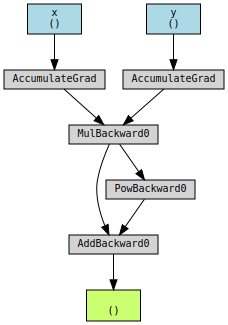

In [17]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)


a1 = x * y
b1 = a1 ** 2
c1 = a1 + b1

print("Computation graph WITHOUT detach:")
dot1 = make_dot(c1, params={"x": x, "y": y})
dot1.render("graph_without_detach", format="png")  # saves as PNG
dot1



In [18]:
c1.backward(retain_graph=True)
print("Gradients WITHOUT detach:")
print("x.grad:", x.grad)
print("y.grad:", y.grad)

Gradients WITHOUT detach:
x.grad: tensor(39.)
y.grad: tensor(26.)


#### Without `.detach()`


Computation graph WITH detach:


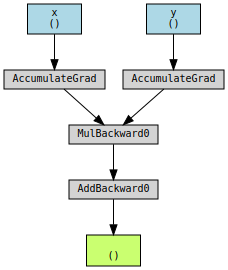

In [19]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

a2 = x * y
b2 = a2.detach() ** 2  # detach a2
c2 = a2 + b2


print("\nComputation graph WITH detach:")
dot2 = make_dot(c2, params={"x": x, "y": y})
dot2.render("graph_with_detach", format="png")
dot2

In [20]:
c2.backward()
print("Gradients WITH detach:")
print("x.grad:", x.grad)
print("y.grad:", y.grad)


Gradients WITH detach:
x.grad: tensor(3.)
y.grad: tensor(2.)


# Training a Simple Neural Network on MNIST with PyTorch

## What is `nn.Module`?

`nn.Module` is the base class for all neural networks in PyTorch.

It provides:
- a structured way to define layers and parameters
- automatic registration of trainable weights
- integration with PyTorch’s autograd system

Any custom neural network must inherit from `nn.Module`
and implement a `forward` method.


In [21]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNet()
print(model)


SimpleNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## What is a Dataset and DataLoader?

A `Dataset` represents a collection of samples and labels.

A `DataLoader`:
- loads data in mini-batches
- shuffles data each epoch
- handles parallel data loading

Together, they allow efficient and scalable training.

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Convert images to tensors
transform = transforms.ToTensor()

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Create DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)


## Loss Functions in PyTorch

A loss function (also called a criterion) measures how well the model’s
predictions match the true targets.

In PyTorch, loss functions are provided in the `torch.nn` module and are
implemented as **callable objects**. They take:
- the model’s output (predictions)
- the ground-truth labels

and return a **single scalar value** representing the error.

This scalar loss is the starting point for backpropagation.

In addition to module-based loss functions, PyTorch also provides functional-style losses in the `torch.nn.functional` package.

### How Loss Functions Fit into Training

During training:
1. The model produces predictions in the forward pass
2. The loss function compares predictions with targets
3. Calling `.backward()` on the loss computes gradients for all parameters

The loss function defines **what the model is trying to optimize**.


In [23]:
criterion = nn.CrossEntropyLoss()

## Optimizers in PyTorch

An optimizer updates the model’s parameters using the gradients computed
during backpropagation.

PyTorch optimizers live in the `torch.optim` module and operate on:
- model parameters (weights and biases)
- gradients stored in `.grad` fields

Optimizers implement different strategies for adjusting parameters to
minimize the loss.

### Common Optimizers in PyTorch

Some commonly used optimizers include:

- `optim.SGD`
  - Stochastic Gradient Descent
  - Simple and widely used
  - Can include momentum for faster convergence

- `optim.Adam`
  - Adaptive learning rate optimizer
  - Works well for many deep learning problems
  - Often a good default choice

- `optim.RMSprop`
  - Uses moving averages of gradients
  - Common in recurrent and reinforcement learning settings

- `optim.Adagrad`
  - Adapts learning rates based on parameter updates
  - Useful for sparse data

### How Optimizers Work in Training

A typical training step looks like this:

1. Compute the loss
2. Call `.backward()` to compute gradients
3. Call `optimizer.step()` to update parameters
4. Call `optimizer.zero_grad()` to clear old gradients

Gradients accumulate by default, so clearing them each step is important.

### Why Optimizers Are Separate from Models

Keeping optimizers separate from the model allows:
- swapping optimization strategies easily
- using different learning rates or optimizers for different parameters
- clean separation between model definition and training logic

The optimizer defines **how the model learns**, while the loss defines
**what the model learns**.


In [24]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01)


## What Happens During Training?

Each training step consists of:
1. Forward pass through the network
2. Loss computation
3. Gradient computation using backpropagation
4. Parameter update using the optimizer


In [25]:
num_epochs = 3

for epoch in range(num_epochs):
    total_loss = 0.0

    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/3], Loss: 1.2328
Epoch [2/3], Loss: 0.4945
Epoch [3/3], Loss: 0.3932


## Defining Custom Datasets in PyTorch

In addition to built-in datasets, PyTorch allows you to define **custom datasets**
by subclassing `torch.utils.data.Dataset`.

To create a custom dataset, you need to implement:
- `__len__()` → returns the total number of samples
- `__getitem__(idx)` → returns one sample (and its label) given an index

This approach gives full control over how data is loaded, transformed,
and returned to the training loop.


In [26]:
import torch
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

# Example usage
data = torch.randn(10, 3)
labels = torch.randint(0, 2, (10,))

dataset = SimpleDataset(data, labels)
print(len(dataset))
print(dataset[0])


10
(tensor([ 1.5743,  0.5281, -0.5232]), tensor(0))


# Homework

## 1. Реализовать операции по графу (максимум 0.2 балла)


### Задание 1.1 (0.05 балл)

![task1.1](assets/task_1.png)

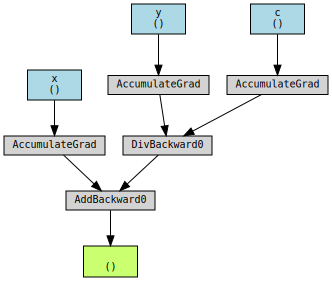

In [27]:
import torch
from torchviz import make_dot

x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)
c = torch.tensor(2.0, requires_grad=True)

# Operations
z = x + y / c
z.backward()

# Visualize graph
dot = make_dot(z, params={"x": x, "y": y, "c": c})

dot



### Задание 1.2 (0.05 балл)


![task1.2](assets/task_2.png)


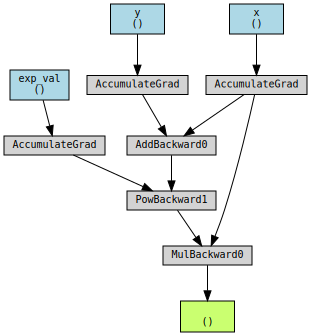

In [28]:
import torch
from torchviz import make_dot

x = torch.tensor(1.5, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
exp_val = torch.tensor(2.0, requires_grad=True)  # tensor for exponent

# Operations
z = x * (x + y) ** exp_val
z.backward()

# Visualize graph
dot = make_dot(z, params={"x": x, "y": y, "exp_val": exp_val})

dot


### Задание 1.3 (0.05 балл)



![task1.3](assets/task_3.png)


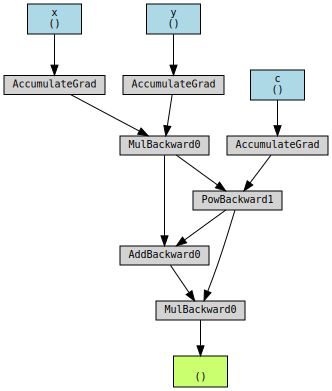

In [29]:
import torch
from torchviz import make_dot

x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(4.0, requires_grad=True)
c = torch.tensor(2.0, requires_grad=True)

# Operations
mult = x * y
pwr = c ** mult
z = pwr * (pwr + mult)
z.backward()

# Visualize graph
dot = make_dot(z, params={"x": x, "y": y, "c": c})

dot


### Задание 1.4 (0.05 балл)


![task1.4](assets/task_4.png)


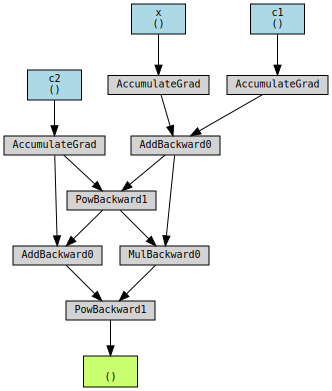

In [30]:
import torch
from torchviz import make_dot

x = torch.tensor(2.0, requires_grad=True)
c1 = torch.tensor(1.0, requires_grad=True)
c2 = torch.tensor(3.0, requires_grad=True)

# Operations
add0 = x + c1
pow1 = add0 ** c2
z = (add0 * pow1) ** (pow1 + c2)
z.backward()

# Visualize graph
dot = make_dot(z, params={"x": x, "c1": c1, "c2": c2})

dot


## 2 Реализовать функции для автоматического дифференциирования (максимум 0.4 балла)



### Задача 2.1: Функция Sinc (0.2 балла)

Реализуйте кастомную `torch.autograd.Function`, которая вычисляет:

$$
\text{sinc}(x) = \frac{\sin(x)}{x}, \quad x \neq 0, \quad \text{sinc}(0) = 1
$$


In [31]:
import torch

class SincFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        result = torch.where(x == 0, torch.tensor(1.0, device=x.device, dtype=x.dtype), torch.sin(x) / x)
        ctx.save_for_backward(x)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        sinc_grad = torch.where(x == 0, torch.tensor(0.0, device=x.device, dtype=x.dtype), (x * torch.cos(x) - torch.sin(x)) / (x ** 2))
        return grad_output * sinc_grad

# ----------------------------
# Тестирование
# ----------------------------
x = torch.tensor([0.0, 1.0, 2.0, 3.0], requires_grad=True)
y = SincFunction.apply(x)
y.sum().backward()

expected_values = torch.tensor([1.0000, 0.8415, 0.4546, 0.0470])
expected_grads = torch.tensor([0.0000, -0.3012, -0.4354, -0.3457])

assert torch.allclose(y, expected_values, atol=1e-4), "Forward Sinc рассчитан неверно"
assert torch.allclose(x.grad, expected_grads, atol=1e-4), "Градиенты Sinc рассчитаны неверно"

print("Задача 2.1: все тесты пройдены ✅")

Задача 2.1: все тесты пройдены ✅


### Задача 2.2: Функция Гаусса (0.2 балла)

Реализуйте кастомную `torch.autograd.Function`, которая вычисляет:

$$
f(x) = e^{-x^2}
$$

In [32]:
class GaussianFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        result = torch.exp(-x**2)
        ctx.save_for_backward(x)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        gaussian_grad = -2 * x * torch.exp(-x**2)
        return grad_output * gaussian_grad

# ----------------------------
# Тестирование
# ----------------------------
x = torch.tensor([-1.0, 0.0, 0.5, 1.0], requires_grad=True)
y = GaussianFunction.apply(x)
y.sum().backward()

expected_values = torch.tensor([0.3679, 1.0000, 0.7788, 0.3679])
expected_grads = torch.tensor([ 0.7358, -0.0000, -0.7788, -0.7358])


assert torch.allclose(y, expected_values, atol=1e-4), "Forward Гаусса рассчитан неверно"
assert torch.allclose(x.grad, expected_grads, atol=1e-4), "Градиенты Гаусса рассчитаны неверно"

print("Задача 2.2: все тесты пройдены ✅")


Задача 2.2: все тесты пройдены ✅


### Задача 3: Реализация пользовательского Dataset синуса и косинуса. (0.1 балл)

Реализуйте свой класс, наследующий `torch.utils.data.Dataset`.

- Для каждого индекса `i` возвращайте пару `(sin(i), cos(i))`
- Размер датасета задается при инициализации
- Проверьте реализацию с помощью `assert`:
  - длина датасета совпадает с указанной
  - значения синуса и косинуса соответствуют ожидаемым


In [33]:
import torch
from torch.utils.data import Dataset
import math

class SinCosDataset(Dataset):
    def __init__(self, data_sz):
        super().__init__()
        self.data_sz = data_sz

    def __len__(self):
        return self.data_sz

    def __getitem__(self, idx):
        sample_sin = torch.tensor(math.sin(idx))
        sample_cos = torch.tensor(math.cos(idx))
        return sample_sin, sample_cos

# ----------------------------
# Тестирование
# ----------------------------
dataset_size = 10
dataset = SinCosDataset(dataset_size)

# 1. Проверяем длину
assert len(dataset) == dataset_size, f"Expected dataset length {dataset_size}, got {len(dataset)}"

# 2. Проверяем значения для нескольких индексов
for i in range(dataset_size):
    x, y = dataset[i]
    expected_x = math.sin(i)
    expected_y = math.cos(i)
    assert math.isclose(x.item(), expected_x, rel_tol=1e-6), f"sin({i}) expected {expected_x}, got {x.item()}"
    assert math.isclose(y.item(), expected_y, rel_tol=1e-6), f"cos({i}) expected {expected_y}, got {y.item()}"

print("Dataset tests passed ✅")


Dataset tests passed ✅


## Задача 4. (0.1 балл)
Вопрос: В каком случае нам полезно использовать накопление градиентов?

Ответ: если мы хотим считать градиент по большей выборке при этом укладываясь в ограничение памяти (можем считать на нескольких батчах и копить его).

## Задача 5. Реализуйте обучение модели на мнист из примера выше на GPU (0.1 балла)

Для того чтобы перевести модель или тензор на GPU можно использовать метод `.cuda()`. Чтобы перевести на CPU - метод `.cpu()`.

Доп.задание (0.1 балл): Реализуйте ответ из задачи 4

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


device = "cuda"

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3
accumulation_steps = 4

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    optimizer.zero_grad()

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()

        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/3], Loss: 1.2387
Epoch [2/3], Loss: 0.4967
Epoch [3/3], Loss: 0.3933
